In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.activations import sigmoid
import pandas as pd
from tf_idf import tf_idf
from sklearn.preprocessing import LabelBinarizer
import os


PATH = "/Users/davidflorezmazuera/Library/CloudStorage/GoogleDrive-270191@student.pwr.edu.pl/Mi unidad/Spanish_V2"

In [4]:
authors_path = os.path.join(PATH, 'authors-genre.csv')
# Load the data
# Load only the columns 1 and 3
dataframe = pd.read_csv(authors_path, usecols=[1,3], sep=';')
dataframe = dataframe.dropna()
print (dataframe.head())


  book_id gender
0     0_0   male
1     1_0   male
2     2_0   male
3     3_0   male
4     4_0   male


In [5]:

# Import metadata_cleaned.json
import sys
#print(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.abspath('')))
from web_scrapping.script import Library, Book

path = os.path.join(PATH, 'metadata_cleaned.json')
library = Library.from_books_path(path)
# Get the words from the metadata of a book or set of books
def get_words_from_metadata(library: Library, book_id: str):
    '''
        Input: library - Library object
               book_id - id of the book
               Output: words - int'''
    id_in_metadata = book_id.split('_')[0]
    # each book in metadata_cleaned.json has an id that is the same that id_in_metadata 
    books = library.search('book_id', id_in_metadata)
    return books[0].words


TimeoutError: [Errno 60] Operation timed out

In [ ]:
# Createe a new column in the dataframe with the words of the book
dataframe['words'] = dataframe['book_id'].apply(lambda book_id: get_words_from_metadata(library, book_id))
print(dataframe.head())

  book_id gender   words
0     0_0   male  108712
1     1_0   male   10160
2     2_0   male    9046
3     3_0   male   10955
4     4_0   male   16000


In [ ]:
# Filter the dataframe to get only the books that have more than 100 words
dataframe = dataframe[dataframe['words'].apply(lambda words: words > 100)]
# Subsampling to get same number of females and males

female_dataframe = dataframe[dataframe['gender']=='female']
male_dataframe = dataframe[dataframe['gender']=='male']
number_of_females = female_dataframe['book_id'].count()
male_dataframe = male_dataframe.sample(n=number_of_females, random_state=1)

mixed_df = pd.concat((female_dataframe,male_dataframe))
dataframe = mixed_df
mixed_df

,book_id,gender,words
77,81_0,female,4718
122,139_0,female,1498
127,1000_0,female,848
137,150_0,female,23487
169,174_0,female,68000
172,177_0,female,9300
256,246_0,female,15243
297,287_0,female,61589
331,320_0,female,395758
337,326_0,female,8781


In [ ]:
# Get the tf_idf of the books in 
# get the books
books = []
for book_id in dataframe['book_id']:
    # get the .txt file
    with open(f"{PATH}/{book_id}.txt") as f:
        book = f.read()
        books.append(book)
X = tf_idf(books)



In [ ]:
# define the X and y
x = X
y = dataframe['gender'].values
x.shape, y.shape

((22, 1000), (22,))

In [ ]:
# One hot encode the labels
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
print(y)
print(y.reshape(-1, 1))
y = enc.fit_transform(y.reshape(-1, 1)).toarray()



['female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'female' 'male' 'male' 'male' 'male' 'male' 'male'
 'male' 'male' 'male' 'male' 'male']
[['female']
 ['female']
 ['female']
 ['female']
 ['female']
 ['female']
 ['female']
 ['female']
 ['female']
 ['female']
 ['female']
 ['male']
 ['male']
 ['male']
 ['male']
 ['male']
 ['male']
 ['male']
 ['male']
 ['male']
 ['male']
 ['male']]


In [ ]:
print(y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((16, 1000), (16, 2), (6, 1000), (6, 2))

In [ ]:
print(y_train)


[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [ ]:
# Create a sequential model that has as input the vectorized text in a dict of 1000 words
# and as output 2 classes (male and female)
model = Sequential()
model.add(Input(shape=(1000,)))
model.add(Dense(units=512))
model.add(Activation(sigmoid))
model.add(Dropout(0.5))
model.add(Dense(units=512))
model.add(Activation(sigmoid))
model.add(Dropout(0.5))
model.add(Dense(units=2))
model.add(Activation('softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(  x=x_train.toarray(), 
            y=y_train,
            batch_size=2,
            epochs=5,
            verbose=1,
            validation_split=0.2,
            shuffle=True)

Epoch 1/5
6/6 [==============================] - 1s 37ms/step - loss: 1.2589 - accuracy: 0.4167 - val_loss: 1.1655 - val_accuracy: 0.2500
Epoch 2/5
6/6 [==============================] - 0s 15ms/step - loss: 1.1221 - accuracy: 0.5000 - val_loss: 1.0227 - val_accuracy: 0.2500
Epoch 3/5
6/6 [==============================] - 0s 15ms/step - loss: 0.8103 - accuracy: 0.5000 - val_loss: 0.5988 - val_accuracy: 0.7500
Epoch 4/5
6/6 [==============================] - 0s 16ms/step - loss: 0.9583 - accuracy: 0.5833 - val_loss: 0.8799 - val_accuracy: 0.2500
Epoch 5/5
6/6 [==============================] - 0s 16ms/step - loss: 0.7440 - accuracy: 0.4167 - val_loss: 0.9525 - val_accuracy: 0.2500


In [ ]:
def transform_y(y):
    '''
        Transform the one hot encoded y to the original y
        '''
    return enc.inverse_transform(y)

1/1 [==============================] - 0s 14ms/step


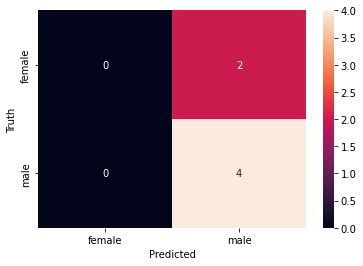

Accuracy: 0.6666666666666666


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(x_test.toarray())
y_pred_transformed = transform_y(y_pred)
y_test_transformed = transform_y(y_test)
cm = confusion_matrix(y_test_transformed, 
                      y_pred_transformed)
# create df so that the labels are in the correct order
df = pd.DataFrame(cm,
                  index=['female','male'],
                  columns=['female','male'])
sns.heatmap(df, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
print('Accuracy: '+ str(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))))